In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [33]:
FILE_IN_NAME = "clustered_v0.csv.gz" # TODO
FILE_OUT_NAME = "length_normalized_v0.csv.gz"

BIN_SIZE = 5

In [34]:
df_in = pd.read_csv(FILE_IN_NAME)
print(df.head())

                 ID latestVersion  globalMetricValue uniprotStart uniprotEnd  \
0  AF-A0A3T1DUE9-F1             4              93.62            1         73   
1  AF-A0A1G0MFV9-F1             4              75.75            1         71   
2  AF-A0A6M1Z002-F1             4              95.00            1         71   
3  AF-A0A7Z7D1Z9-F1             4              95.50            1         71   
4  AF-A0A529X7M2-F1             4              91.81            1         74   

                                     uniprotSequence  Length Max Topology  \
0  MLSQRRGLVAHPGMANACPRGISDPTLLLVGPEGGFIAWEVEQLLL...    73.0          3_1   
1  MLLWIGLTASAAAIVYSGTKLSRYGDVIAEKTGMGRTWIGVLLMAS...    71.0          NaN   
2  MPAFFGDLSPEAPRFTPPSSDLLIFIGPESGFSDEEIALLQGPLKG...    71.0          3_1   
3  MFGTESTGIPKKIMQDKIANCLRIPMNAQCRSLNLANSVAIVLYEI...    71.0          NaN   
4  LGFSQLALSPHGETDIRAAERTSRLALYLGTEGEGLPEALLERLRT...    74.0          3_1   

   Max Freq Knot Core label  bin_len  
0     0.506   (9,

In [35]:
df_pos = df_in[df_in['Max Topology'].notnull()]
df_neg = df_in[df_in['Max Topology'].isnull()]

### Preprocess dataset

In [36]:
df_pos = df_pos.assign(label=1)
df_neg = df_neg.assign(label=0)

Sequence length is considered in bins of size BIN_SIZE (currently 5)

In [37]:
df_pos = df_pos.assign(bin_len = df_pos['Length'].apply(lambda x: x - x % BIN_SIZE))
df_neg = df_neg.assign(bin_len = df_neg['Length'].apply(lambda x: x - x % BIN_SIZE))

df_pos = df_pos.sort_values(by=['bin_len'])
df_neg = df_neg.sort_values(by=['bin_len'])

df_pos = df_pos.reset_index(drop=True)
df_neg = df_neg.reset_index(drop=True)

### Make new dataset with similar positive and negative sequence length distribution

In [38]:
pos = 0
neg = 0

df = pd.DataFrame(columns=df_pos.columns)

pbar = tqdm(total = len(df_pos))

while pos < len(df_pos) and neg < len(df_neg):
    if df_pos['bin_len'][pos] == df_neg['bin_len'][neg]:
        df = pd.concat([df, df_pos.iloc[[pos]]], ignore_index=True)
        df = pd.concat([df, df_neg.iloc[[neg]]], ignore_index=True)
        pos += 1
        neg += 1
        pbar.update(1)
    elif df_pos['bin_len'][pos] > df_neg['bin_len'][neg]:
        neg += 1
    else:
        pos += 1
        pbar.update(1)
        
pbar.close()

print(df)

100%|██████████| 204440/204440 [19:15<00:00, 176.89it/s] 

                      ID latestVersion  globalMetricValue uniprotStart  \
0       AF-A0A3T1DUE9-F1             4              93.62            1   
1       AF-A0A1G0MFV9-F1             4              75.75            1   
2       AF-A0A6M1Z002-F1             4              95.00            1   
3       AF-A0A7Z7D1Z9-F1             4              95.50            1   
4       AF-A0A529X7M2-F1             4              91.81            1   
...                  ...           ...                ...          ...   
205989  AF-A0A669C463-F1             4              72.69            1   
205990  AF-A0A1V9Y6D9-F1             4              76.44            1   
205991  AF-A0A7N6ADZ2-F1             4              77.00            1   
205992      AF-W2R2X0-F1             4              74.31            1   
205993  AF-A0A401SDS5-F1             4              82.50            1   

       uniprotEnd                                    uniprotSequence  Length  \
0              73  MLSQRRGLVAHP

In [39]:
df = df.drop(columns='bin_len')
df.to_csv(FILE_OUT_NAME, index=False)

In [40]:
print(f"Positives: {len(df[df['label'] == 1])}")
print(f"Negatives: {len(df[df['label'] == 0])}")

Positives: 102997
Negatives: 102997


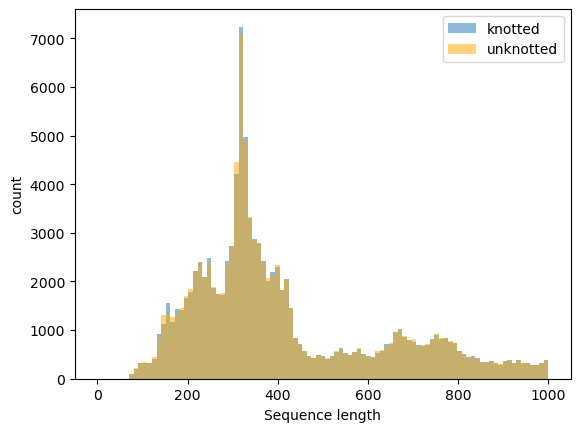

In [41]:
plt.hist(df[df['label'] == 1]['Length'].tolist(), bins=np.linspace(0, 1000, 100), alpha=0.5, label='knotted')

plt.hist(df[df['label'] == 0]['Length'].tolist(), bins=np.linspace(0, 1000, 100), alpha=0.5, color='orange', label='unknotted')

plt.legend()
plt.xlabel('Sequence length')
plt.ylabel('count')

plt.show()